In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import os
from constants import (DATASET_5M, USECOLS, EXPORT_DIR,T, DATA_DIR,
                       ALL_DATA_PATH, TRAIN_DATA_PATH, VAL_DATA_PATH, TEST_DATA_PATH, VAL_THRESHOLD, TEST_THRESHOLD)
import scipy
print(f"SciPy version: {scipy.__version__}")
from collections import OrderedDict
import scipy.sparse as sp
import time
import random

SciPy version: 1.5.2


In [2]:
import matplotlib.pyplot as plt
FONT_SIZE = 24
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = FONT_SIZE
plt.rcParams['legend.fontsize'] = FONT_SIZE
plt.rcParams['xtick.labelsize'] = FONT_SIZE
plt.rcParams['ytick.labelsize'] = FONT_SIZE
%config InlineBackend.figure_format ='retina'
# %matplotlib widget

In [3]:
EVENT_THRESHOLD = 5

# EDA

In [4]:
%%time
df = pd.concat((pd.read_csv(DATASET_5M+file,engine='c', sep=',',usecols=USECOLS) for file in os.listdir(DATASET_5M)))
df["event_type"] = df["event_type"].astype("category")
df["product_id"] = df["product_id"].astype("int32")
df["user_id"] = df["user_id"].astype("int32")
df["price"] = df["product_id"].astype("float32")
df['event_time'] = pd.to_datetime(df['event_time'],infer_datetime_format=True)
# df = df.sort_values(by='event_time', kind='mergesort')
df

Wall time: 4min 24s


,event_time,event_type,product_id,price,user_id
0,2019-12-01 00:00:00+00:00,remove_from_cart,5712790,5712790.0,576802932
1,2019-12-01 00:00:00+00:00,view,5764655,5764655.0,412120092
2,2019-12-01 00:00:02+00:00,cart,4958,4958.0,494077766
3,2019-12-01 00:00:05+00:00,view,5848413,5848413.0,348405118
4,2019-12-01 00:00:07+00:00,view,5824148,5824148.0,576005683
...,...,...,...,...,...
4264747,2020-01-31 23:59:52+00:00,remove_from_cart,5886774,5886774.0,607092857
4264748,2020-01-31 23:59:52+00:00,remove_from_cart,5886774,5886774.0,607092857
4264749,2020-01-31 23:59:53+00:00,view,5875432,5875432.0,423651741
4264750,2020-01-31 23:59:57+00:00,remove_from_cart,5820745,5820745.0,607092857


In [5]:
start_dim = df.shape
start_dim

(20692840, 5)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20692840 entries, 0 to 4264751
Data columns (total 5 columns):
 #   Column      Dtype              
---  ------      -----              
 0   event_time  datetime64[ns, UTC]
 1   event_type  category           
 2   product_id  int32              
 3   price       float32            
 4   user_id     int32              
dtypes: category(1), datetime64[ns, UTC](1), float32(1), int32(2)
memory usage: 572.3 MB


# Event types in the dataset

In [7]:
event_counts = df.event_type.value_counts()
event_counts

view                9657821
cart                5768333
remove_from_cart    3979679
purchase            1287007
Name: event_type, dtype: int64

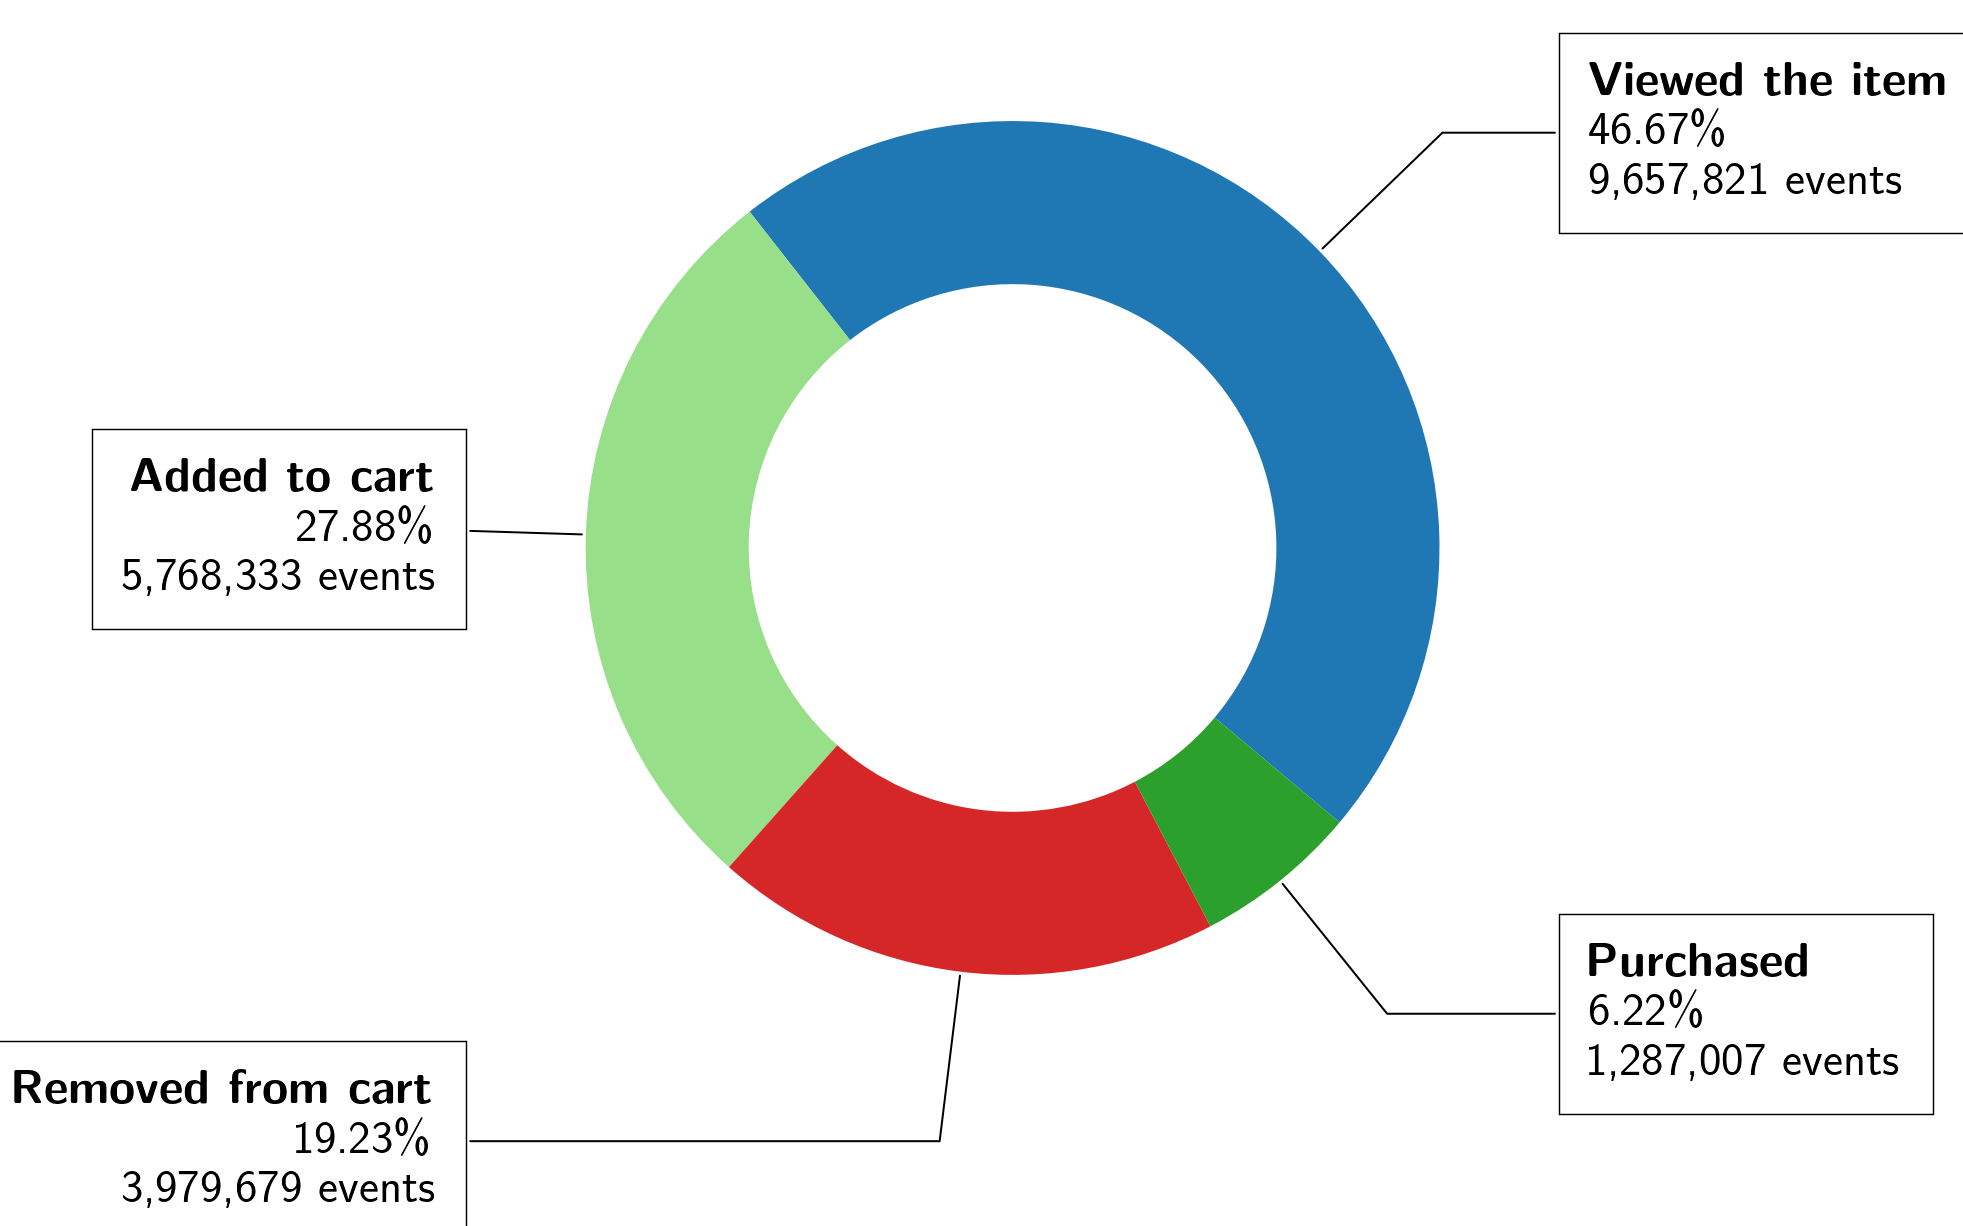

In [8]:
fig, ax = plt.subplots(figsize=(16, 9), subplot_kw=dict(aspect="equal"))
# W - width; P - precision; B - bold; N - normal
W = 2
P = 2
E = 'events'
event_counts = df.event_type.value_counts()
event_perc = df.event_type.value_counts(normalize=True) * 100
event_type_legend = [r"\textbf{Viewed the item}"+f"\n{event_perc['view']:{W}.{P}f}\%\n{event_counts['view']:,} {E}",
                     r"\textbf{Added to cart}"+f"\n{event_perc['cart']:{W}.{P}f}\%\n{event_counts['cart']:,} {E}",
                     r"\textbf{Removed from cart}"+f"\n{event_perc['remove_from_cart']:{W}.{P}f}\%\n{event_counts['remove_from_cart']:,} {E}",
                     r"\textbf{Purchased}"+f"\n{event_perc['purchase']:{W}.{P}f}\%\n{event_counts['purchase']:,} {E}"]

cmap = plt.get_cmap("tab20")
wedges, texts = ax.pie(event_counts, wedgeprops=dict(width=0.382), textprops=dict(color="w"), startangle=-40, colors=cmap([0,5,6,4]))

bbox_props = dict(boxstyle="square,pad=0.618", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(event_type_legend[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)
fig.set_facecolor('w')
# ax.set_title("Logged user events")
plt.tight_layout()

# fig.savefig(EXPORT_DIR+'percentage-of-events.png',dpi=300)
# fig.savefig(EXPORT_DIR+'percentage-of-events.pdf')
plt.show()

In [9]:
users_events_crosstab=pd.crosstab(df['user_id'],df['event_type'])
users_events_crosstab.sort_values(by='view',ascending=False)

event_type,cart,purchase,remove_from_cart,view
user_id,,,,
527021202,4292,0,1968,20492
557616099,217,9,151,9526
583884978,1,0,1,9418
550388516,5,0,12,7539
557956487,298,38,230,7169
...,...,...,...,...
591525847,9,0,0,0
576843109,1,0,0,0
450980229,1,0,0,0


In [10]:
users = df['user_id'].value_counts()

# Top 3 most active users (based on the number of views)

In [11]:
users_events_crosstab.loc[users.index[0]]

event_type
cart                 4292
purchase                0
remove_from_cart     1968
view                20492
Name: 527021202, dtype: int64

In [12]:
users_events_crosstab.loc[users.index[1]]

event_type
cart                 217
purchase               9
remove_from_cart     151
view                9526
Name: 557616099, dtype: int64

In [13]:
users_events_crosstab.loc[users.index[2]]

event_type
cart                   1
purchase               0
remove_from_cart       1
view                9418
Name: 583884978, dtype: int64

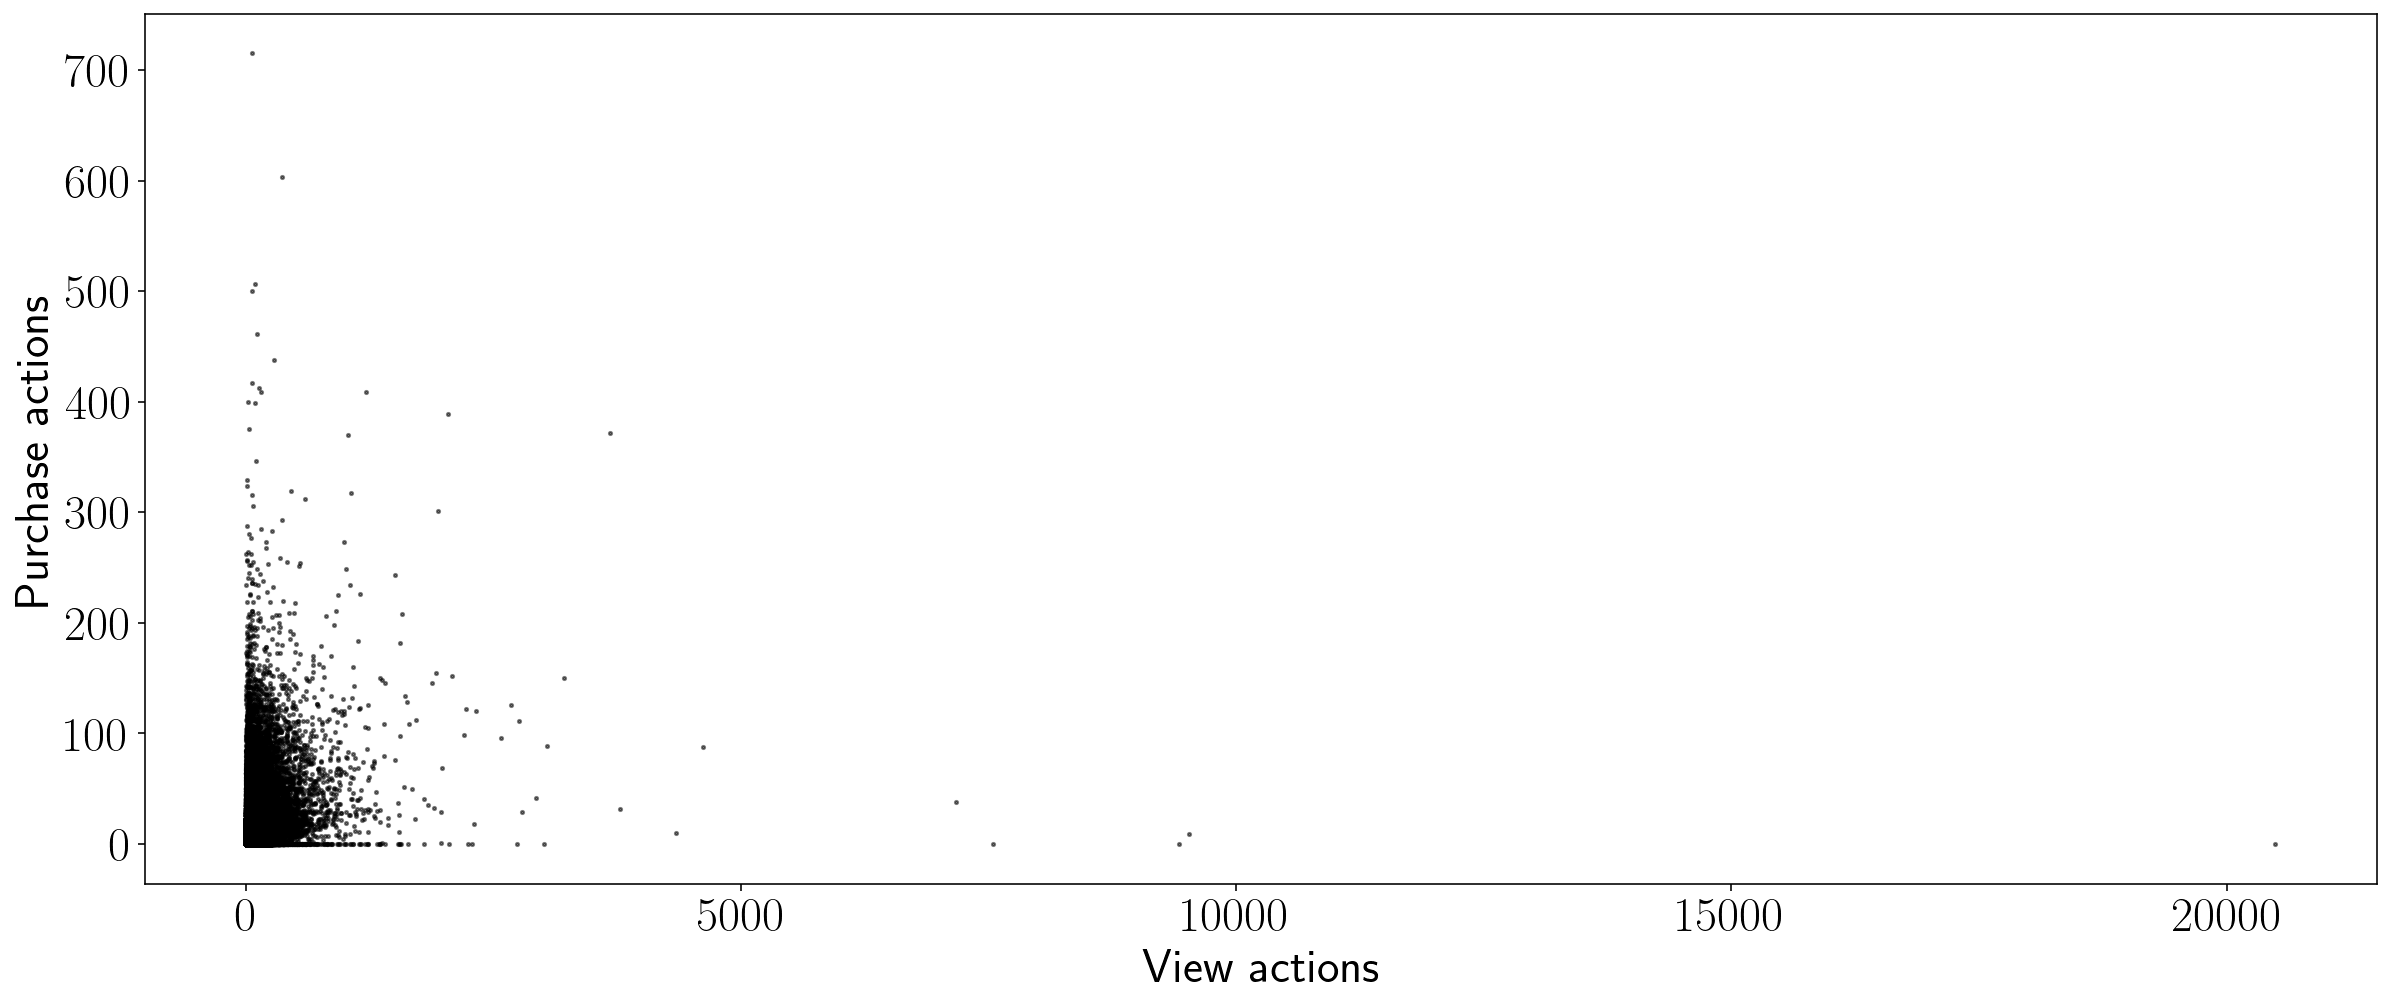

In [14]:
plt.scatter(users_events_crosstab['view'], users_events_crosstab['purchase'], marker='.',color='k',alpha=0.5,s=10)
# plt.title('Number of views and number of purchase actions for the same user.')
plt.xlabel('View actions')
plt.ylabel('Purchase actions')
# plt.savefig(EXPORT_DIR+'view-purchase-per-user.png',dpi=300)
plt.show()

In [15]:
print(f"The Pearson product-moment correlation coefficient is R={np.corrcoef(users_events_crosstab['view'], users_events_crosstab['purchase'])[0,1]:.4f}.")

The Pearson product-moment correlation coefficient is R=0.3606.


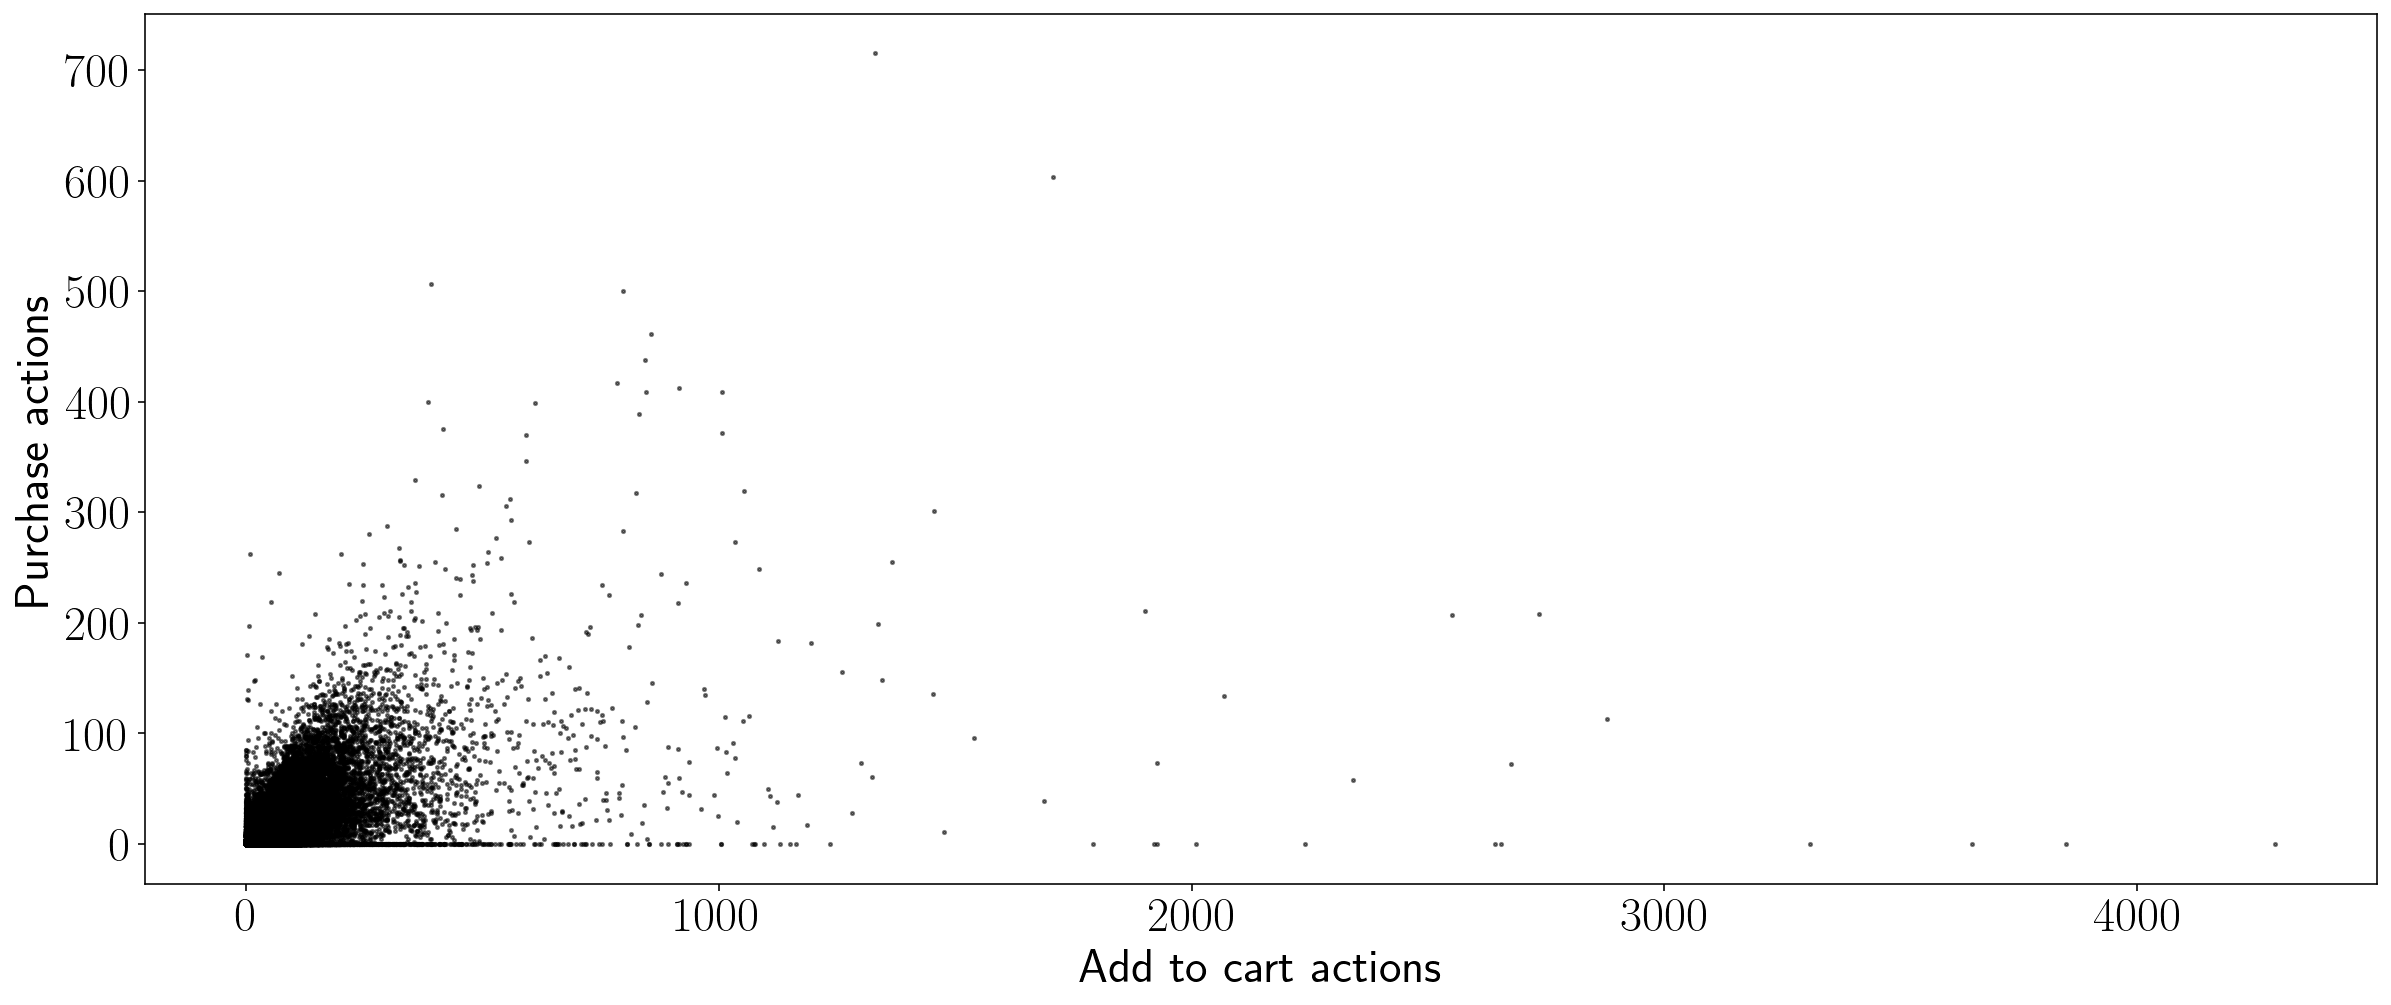

In [16]:
plt.scatter(users_events_crosstab['cart'], users_events_crosstab['purchase'], marker='.',color='k',alpha=0.5,s=10)
# plt.title('Number of add to cart actions and number of purchase actions for the same user.')
plt.xlabel('Add to cart actions')
plt.ylabel('Purchase actions')
# plt.savefig(EXPORT_DIR+'cart-purchase-per-user.png',dpi=300)
plt.show()

In [17]:
print(f"The Pearson product-moment correlation coefficient is R={np.corrcoef(users_events_crosstab['cart'], users_events_crosstab['purchase'])[0,1]:.4f}.")

The Pearson product-moment correlation coefficient is R=0.6264.


# Traffic fluctuation during the observed daterange

In [18]:
fluct = df.loc[:,['event_time','user_id']]
fluct['day'] = fluct['event_time'].apply(lambda s: str(s)[0:10])

In [19]:
daily_visitors = fluct.drop_duplicates().groupby(['day'])['user_id'].agg(['count']).sort_values(by=['day'], ascending=True)
daily_visitors.head()

,count
day,
2019-10-01,126245
2019-10-02,181132
2019-10-03,109820
2019-10-04,102356
2019-10-05,94707


In [20]:
X = pd.Series(daily_visitors.index.values).apply(lambda s: dt.strptime(s, '%Y-%m-%d').date())

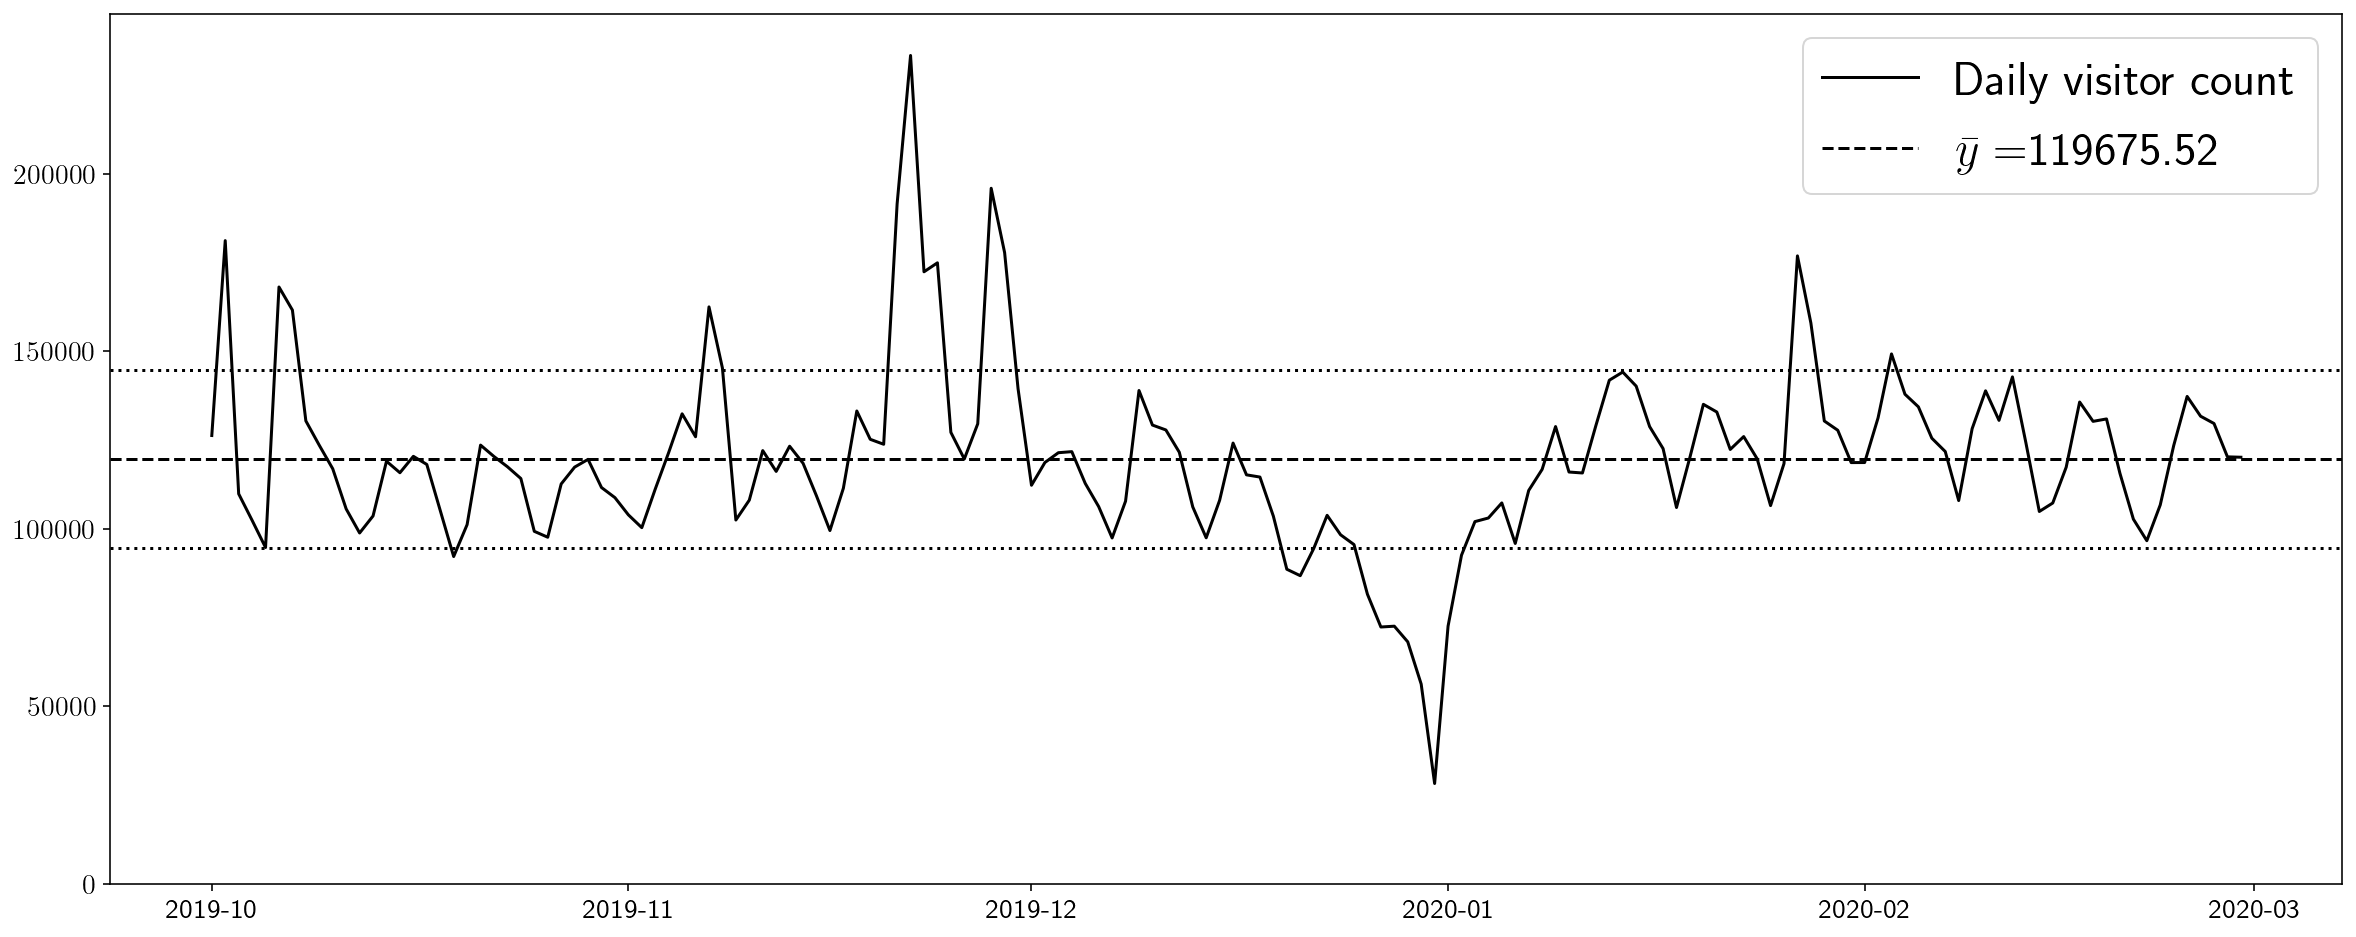

In [21]:
s = daily_visitors.std()[0]
y_bar = daily_visitors.mean()[0]
ax = plt.subplot()

plt.plot(X,daily_visitors['count'],color='k')
plt.ylim((0,daily_visitors['count'].max()*1.05))
plt.axhline(y = y_bar,linestyle='--', color='k')
plt.axhline(y = y_bar+s,linestyle=':', color='k')
plt.axhline(y = y_bar-s,linestyle=':', color='k')

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(14)

plt.legend(['Daily visitor count', r"$\bar{y}=$"+f"{daily_visitors.mean()[0]:.2f}"])
# plt.savefig(EXPORT_DIR+'daily-visitor-count.png',dpi=300)
# plt.savefig(EXPORT_DIR+'daily-visitor-count.pdf')
plt.show()

In [22]:
buyers_df = df[df.event_type=='purchase']
buyers_df = buyers_df.drop(columns=['event_type'])
assert len(buyers_df) == event_counts['purchase'], "The number of purchase events should stay the same, regardless of the calculation method."
buyers_df.tail(3)

,event_time,product_id,price,user_id
4264716,2020-01-31 23:58:26+00:00,5867185,5867185.0,604470329
4264717,2020-01-31 23:58:26+00:00,5877766,5877766.0,604470329
4264718,2020-01-31 23:58:26+00:00,5905704,5905704.0,604470329


In [ ]:
print(f'Total number of visitors in the observed data-range: {daily_visitors.sum().item():,}')

In [ ]:
print(f'Total number of unique visitors in the observed data-range: {len(df.user_id.unique()):,}')

In [ ]:
print(f"Number of events with missing user_id: {len(df[df.user_id.isnull()])}")

# Steps in the user journey

In [66]:
step = pd.Series(dtype='int64')

In [67]:
def pair_id_creator(df,event_type):
    pairs=df[df['event_type']==event_type][['user_id','product_id']].drop_duplicates().sort_values('user_id')
    pairs['pair_id'] = pairs['user_id'].astype(str)+'-'+pairs['product_id'].astype(str)
    return set(pairs['pair_id'])

In [68]:
view_pairs = pair_id_creator(df,'view')
cart_pairs = pair_id_creator(df,'cart')
remove_pairs = pair_id_creator(df,'remove_from_cart')
purchase_pairs = pair_id_creator(df,'purchase')

In [69]:
step['view_cart'] = len(view_pairs.intersection(cart_pairs))
step['cart_remove'] = len(cart_pairs.intersection(remove_pairs))
step['cart_purchase'] = len(cart_pairs.intersection(purchase_pairs))
step['view_purchase'] = len(view_pairs.intersection(purchase_pairs))
step['remove_purchase'] = len(remove_pairs.intersection(purchase_pairs))
step

view_cart          1445354
cart_remove        2101411
cart_purchase      1126468
view_purchase       484433
remove_purchase     174325
dtype: int64

In [70]:
print(f"Chance for a viewed item to be added to cart: {step['view_cart']/event_counts['view']:.5f}")

Chance for a viewed item to be added to cart: 0.14966


In [71]:
print(f"Chance for an item in cart to be removed from it: {step['cart_remove']/event_counts['cart']:.5f}")

Chance for an item in cart to be removed from it: 0.36430


In [72]:
print(f"Chance for an item in cart to be purchased: {step['cart_purchase']/event_counts['cart']:.5f}")

Chance for an item in cart to be purchased: 0.19528


In [73]:
print(f"Chance for an item in cart be abandoned: {1-(step['cart_purchase']/event_counts['cart']+step['cart_remove']/event_counts['cart']):.5f}")

Chance for an item in cart be abandoned: 0.44041


In [74]:
print(f"Chance for a viewed item to be purchased: {step['view_purchase']/event_counts['view']:.5f}")

Chance for a viewed item to be purchased: 0.05016


In [75]:
print(f"Chance for an item removed from cart to be purchased: {step['remove_purchase']/event_counts['remove_from_cart']:.5f}")

Chance for an item removed from cart to be purchased: 0.04380


In [76]:
ux_constants = pd.Series(dtype='int64')

ux_constants['view_to_purchase'] = step['view_purchase']/event_counts['view']
ux_constants['cart_to_purchase'] = step['cart_purchase']/event_counts['cart']
ux_constants['remove_to_purchase'] = step['remove_purchase']/event_counts['remove_from_cart']
ux_constants['purchase_to_purchase'] = 1

In [77]:
ux_constants

view_to_purchase        0.050160
cart_to_purchase        0.195285
remove_to_purchase      0.043804
purchase_to_purchase    1.000000
dtype: float64

In [78]:
ux_constants.to_csv(DATA_DIR+'ux-constants-5m.csv', index = True, header=False)

# Data reduction

In [4]:
ux_constants = pd.Series(pd.read_csv(DATA_DIR+'ux-constants-5m.csv', index_col=0, squeeze=True, header=None), dtype='float32')
VIEW     = ux_constants['view_to_purchase']
CART     = ux_constants['cart_to_purchase']
REMOVE   = ux_constants['remove_to_purchase']
PURCHASE = ux_constants['purchase_to_purchase']

In [5]:
print(ux_constants)

0
view_to_purchase        0.050160
cart_to_purchase        0.195285
remove_to_purchase      0.043804
purchase_to_purchase    1.000000
Name: 1, dtype: float32


In [6]:
def event_to_ux(event):
    event_weights = {
        'view': VIEW,
        'cart': CART,
        'remove_from_cart': REMOVE,
        'purchase': PURCHASE,   
    }
    return event_weights.get(event, 0)

In [7]:
%%time
df = pd.concat((pd.read_csv(DATASET_5M+file,engine='c', sep=',',
                            usecols=["event_type","product_id","user_id"],
                           dtype={'product_id': np.int64, 'user_id': np.int64, 'event_type': 'category'}
                           ) for file in os.listdir(DATASET_5M)))

Wall time: 11 s


In [8]:
df

,event_type,product_id,user_id
0,remove_from_cart,5712790,576802932
1,view,5764655,412120092
2,cart,4958,494077766
3,view,5848413,348405118
4,view,5824148,576005683
...,...,...,...
4264747,remove_from_cart,5886774,607092857
4264748,remove_from_cart,5886774,607092857
4264749,view,5875432,423651741
4264750,remove_from_cart,5820745,607092857


In [9]:
start_dim = df.shape
start_dim

(20692840, 3)

In [10]:
print(f"We start with {len(df.user_id.unique()):,} unique users.")

We start with 1,639,358 unique users.


In [11]:
drop_visitors = set(df.user_id.value_counts()[df.user_id.value_counts()<EVENT_THRESHOLD].index)
print(f"We will {T.R}drop {len(drop_visitors):,} ({len(drop_visitors)*100/len(df.user_id.unique()):.2f}%) users,{T.E} "+
      f"for not meeting the minimum {T.R}{EVENT_THRESHOLD}{T.E} event requirement.")

We will drop 1,243,312 (75.84%) users, for not meeting the minimum 5 event requirement.


In [12]:
df = df[~df.user_id.isin(drop_visitors)]
df.reset_index(inplace=True,drop=True)

In [13]:
print(f"This way we have reduced the number of total events by {T.G}{100-len(df)*100/start_dim[0]:.2f}%{T.E}.")

This way we have reduced the number of total events by 10.00%.


In [14]:
new_user_id = pd.DataFrame()
new_user_id['user_id']=df.user_id.unique()
print(f"We will have {T.B}{len(new_user_id):,} unique users.{T.E}")
new_user_id.to_csv(DATA_DIR+'new-user-id-5m.csv', index = True, header=True)
uid_lookup = pd.Series(index=new_user_id.user_id,data=new_user_id.index)
uid_lookup = uid_lookup.to_dict(OrderedDict)
del new_user_id

We will have 396,046 unique users.


In [15]:
new_product_id = pd.DataFrame()
new_product_id['product_id']=df.product_id.unique()
print(f"We will have {T.B}{len(new_product_id):,} unique features{T.E} (products for e-commerce).")
new_product_id.to_csv(DATA_DIR+'new-product-id-5m.csv', index = True, header=True)
pid_lookup = pd.Series(index=new_product_id.product_id,data=new_product_id.index)
pid_lookup = pid_lookup.to_dict(OrderedDict)
del new_product_id

We will have 53,619 unique features (products for e-commerce).


# Feature engineering

In [16]:
start_time = time.time()
number_of_users = df['user_id'].unique().shape[0]
number_of_features = df['product_id'].unique().shape[0]

In [17]:
def user_experience_matrix(df):
    last_index = df.shape[0]-1      
    # Use np.float32 for torch.cuda.FloatTensor.or np.float16 for torch.cuda.HalfTensor (float64 not recommended)
    uxm = sp.dok_matrix((number_of_users, number_of_features), dtype=np.float32)   
    print(f"   Event |   User | Product | Event | Previous |   {T.b}New UX{T.E}")
    
    for row in df.itertuples():        
        uid = uid_lookup[row.user_id]
        pid = pid_lookup[row.product_id]        
        prev_ux = uxm[uid,pid]
        ux = np.tanh(prev_ux+event_to_ux(row.event_type))   
#       ux = prev_ux + 1 # test case calculating the number of events between the user-product pair
        uxm[uid,pid] = ux        
        if (row.Index % 500000 == 0) or (row.Index == last_index):
            print(f"{row.Index:8} | "+
                  f"{uid:6} | "+
                  f"{pid:7} |  "+
                  f"{row.event_type[:4]} | "+
                  f"{prev_ux:8.5f} | "+
                  f"{T.b}{ux:8.5f}{T.E}")       
    return uxm

In [18]:
%%time
uxm = user_experience_matrix(df)

   Event |   User | Product | Event | Previous |   New UX
       0 |      0 |       0 |  remo |  0.00000 |  0.04378
  500000 |  30551 |      27 |  view |  0.00000 |  0.05012
 1000000 |  52259 |    8585 |  cart |  0.00000 |  0.19284
 1500000 |  69639 |     198 |  view |  0.00000 |  0.05012
 2000000 |  27028 |    1020 |  cart |  0.60878 |  0.66630
 2500000 |  88038 |     783 |  cart |  0.00000 |  0.19284
 3000000 | 118871 |    3650 |  view |  0.00000 |  0.05012
 3500000 |  46808 |    3194 |  remo |  0.19284 |  0.23232
 4000000 | 148903 |   15473 |  remo |  0.09994 |  0.14276
 4500000 | 144370 |   26734 |  cart |  0.00000 |  0.19284
 5000000 |  28150 |   39026 |  view |  0.00000 |  0.05012
 5500000 | 181196 |    3098 |  view |  0.00000 |  0.05012
 6000000 |  25948 |    2814 |  remo |  0.00000 |  0.04378
 6500000 |   7498 |    7657 |  remo |  0.39148 |  0.40973
 7000000 |  27219 |    9803 |  view |  0.00000 |  0.05012
 7500000 | 145332 |    1127 |  cart |  0.00000 |  0.19284
 8000000 | 217

In [19]:
print(f"Elapsed time: {time.time()-start_time:.2f} seconds")

Elapsed time: 434.08 seconds


# Datasplit

In [20]:
def save_to_npz(X,path):
    X = X.tocoo()
    sp.save_npz(path,X)
    print(f"{T.G}Sparse matrix saved to: {path}{T.E}")

In [21]:
print(f"Train: {VAL_THRESHOLD*100:.2f}% \nValidation: {(1-TEST_THRESHOLD)*100:.2f}% \nTest: {(1-TEST_THRESHOLD)*100:.2f}%")

Train: 70.00% 
Validation: 15.00% 
Test: 15.00%


In [22]:
NNZ = uxm.nnz
print(f"Number of stored values: {NNZ:,}")

Number of stored values: 8,543,328


In [23]:
%%time
uxm_train = sp.dok_matrix.copy(uxm)
uxm_val = sp.dok_matrix((number_of_users, number_of_features), dtype=np.float32) 
uxm_test = sp.dok_matrix((number_of_users, number_of_features), dtype=np.float32) 

Wall time: 1min 9s


In [24]:
%%time
rows,cols = uxm_train.nonzero()
for row,col in zip(rows,cols):
    rnd = random.random()
    if rnd > TEST_THRESHOLD:
        uxm_test[row,col] = uxm_train[row,col]
        uxm_train[row,col] = 0
    elif rnd > VAL_THRESHOLD:
        uxm_val[row,col] = uxm_train[row,col]
        uxm_train[row,col] = 0   

Wall time: 1min 23s


In [25]:
print(f"Number of train data values: {uxm_train.nnz:,} ({uxm_train.nnz*100/NNZ:.2f}%)")
print(f"Number of validation data values: {uxm_val.nnz:,} ({uxm_val.nnz*100/NNZ:.2f}%)")
print(f"Number of test data values: {uxm_test.nnz:,} ({uxm_test.nnz*100/NNZ:.2f}%)")
errormessage = '''All datapoints should be in either the train, the test of the validation datasets. 
The reason might be a change in how .nnz of a DOK matrix (scipy.sparse.dok_matrix) is calculated. 
In version 1.5.2 SciPy setting the value to zero explicitly (X[i,j]=0) is not counted by .nnz'''
assert NNZ - uxm_train.nnz - uxm_val.nnz - uxm_test.nnz == 0, errormessage

Number of train data values: 5,979,784 (69.99%)
Number of validation data values: 1,280,698 (14.99%)
Number of test data values: 1,282,846 (15.02%)


In [26]:
# save_to_npz(uxm,ALL_DATA_PATH)
# save_to_npz(uxm_train,TRAIN_DATA_PATH)
# save_to_npz(uxm_val,VAL_DATA_PATH)
# save_to_npz(uxm_test,TEST_DATA_PATH)

Sparse matrix saved to: ./data/uxm.npz
Sparse matrix saved to: ./data/uxm_train.npz
Sparse matrix saved to: ./data/uxm_val.npz
Sparse matrix saved to: ./data/uxm_test.npz
